In [25]:
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
import cv2
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [26]:
def print_in_color(txt_msg,fore_tupple= (0,255,255) ,back_tupple=(0,0,0)):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat))
    print('\33[0m', end='') # returns default print color to back to black

In [27]:
fpath=r'/home/rharikr3/train/REAL/0000 (10).jpg'
img=cv2.imread(fpath)
print('Image shape is ', img.shape)

Image shape is  (32, 32, 3)


In [28]:
limiter = 20000
test_dir=r'/home/rharikr3/test'
train_dir=r'/home/rharikr3/train'
classes=sorted(os.listdir(train_dir))
print('there are ', len(classes), ' classes ', classes[0], ' and ', classes[1])
dir_list=[train_dir, test_dir]
names=['train', 'test']
zip_list=zip(names, dir_list)
for name, dir in zip_list:
    filepaths=[]
    labels=[]
    class_list=sorted(os.listdir(dir))
    for klass in class_list:
        classpath=os.path.join(dir, klass)
        flist=sorted(os.listdir(classpath))
        if name == 'train':
            flist=np.random.choice(flist, limiter, replace=False) # randomly select limiter number of files from train_dir for each class
        desc=f'{name}-{klass}'
        for f in tqdm(flist, ncols=100, colour='blue', unit='files', desc=desc):
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    if name == 'train':
        train_df=pd.concat([Fseries, Lseries], axis=1)
        train_df, valid_df=train_test_split(train_df, test_size=.1, shuffle=True, random_state=123, stratify=train_df['labels'])
    else:  
        test_df=pd.concat([Fseries, Lseries], axis=1)
print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df)) 

there are  2  classes  FAKE  and  REAL


test-REAL: 100%|██████████████████████████████████████| 10000/10000 [00:00<00:00, 1004936.63files/s]

train_df length:  36000   test_df length:  20000   valid_df length:  4000


In [29]:
gen=ImageDataGenerator()
# I will be using an EfficientNet model which requires a minimum image size of 32 X 32
img_size=(32,32)
bs=200 # set the batch size
train_gen=gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                 class_mode= 'categorical', color_mode='rgb', shuffle=True, batch_size=bs)
valid_gen=gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                 class_mode= 'categorical', color_mode='rgb', shuffle=False, batch_size=bs)
test_gen=gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                 class_mode= 'categorical', color_mode='rgb', shuffle=False, batch_size=bs)
labels=test_gen.labels

Found 36000 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.
Found 20000 validated image filenames belonging to 2 classes.


In [30]:
def F1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [35]:
img_shape=(img_size[0], img_size[1], 3)
base_model=tf.keras.applications.EfficientNetV2B0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)       
output=Dense(2, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy', F1_score]) 

In [40]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch, batches, dwell=True, factor=.4): # initialization of the callback
        super(LR_ASK, self).__init__()
        self._model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.lowest_aloss=np.inf
        self.best_weights=self._model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1        
        self.dwell= dwell
        self.factor=factor
        self.header=True
        self.batches=batches
    
    def on_train_begin(self, logs=None): # this runs on the beginning of training 
        msg1 =f'Training will proceed until epoch {self.ask_epoch} then you will be asked to\n'
        msg2='enter H to halt training or enter an integer for how many more epochs to run then be asked again'
        print_in_color(msg1 + msg2)
        if self.dwell:
            msg='learning rate will be automatically adjusted during training'
            print_in_color(msg, (0,255,0))
        self.start_time= time.time() # set the time at which training started
       
    def on_train_end(self, logs=None):   # runs at the end of training  
        msg=f'loading model with weights from epoch {self.best_epoch}'
        print_in_color(msg, (0,255,255))
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color (msg) # print out training duration time
   
    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()
    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')
        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}- accuracy=  {3:5.3f} - loss: {4:8.5f}          '.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        if self.header == True:
            msg = '{0:^7s}{1:^9s}{2:^9s}{3:^9s}{4:^10s}{5:^13s}{6:^10s}{7:^13s}{8:13s}\n'
            msg1=msg.format('Epoch', 'Train', 'Train', 'Valid', 'Valid','V_Loss %', 'Learning','Next LR' ,'Duration in')
            msg='{0:^7s}{1:^9s}{2:^9s}{3:^9s}{4:^10s}{5:^13s}{6:^10s}{7:^13s}{8:13s}'
            msg2=msg.format(' ', 'Loss', 'Accuracy', 'Loss', 'Accuracy','Improvement', 'Rate', 'Rate', '  Seconds') 
            print_in_color (msg1 + msg2)
            self.header=False
        ep_end = time.time()
        duration = ep_end - self.ep_start        
        vloss=logs.get('val_loss')  # get the validation loss for this epoch
        aloss=logs.get('loss')
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate)) # get the current learning rate
        if epoch >0:
            deltav = self.lowest_vloss- vloss 
            pimprov=(deltav/self.lowest_vloss) * 100
            deltaa=self.lowest_aloss-aloss
            aimprov=(deltaa/self.lowest_aloss) * 100            
        else:
            pimprov=0.0             
        if vloss< self.lowest_vloss:
            self.lowest_vloss=vloss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1 
            new_lr=lr
            msg = '{0:^7s}{1:^9.4f}{2:^9.2f}{3:^9.4f}{4:^10.2f}{5:^13.2f}{6:^10.6f}{7:11.6f}{8:^15.2f}'
            msg=msg.format(str(epoch+1), aloss, acc*100, vloss, v_acc*100, pimprov, lr, new_lr,duration)         
            print_in_color(msg, (0,255,0)) # green foreground
        else: # validation loss increased                     
            if self.dwell: # if dwell is True when the validation loss increases the learning rate is automatically reduced and model weights are set to best weights
                lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                new_lr=lr * self.factor
                msg = '{0:^7s}{1:^9.4f}{2:^9.2f}{3:^9.4f}{4:^10.2f}{5:^13.2f}{6:^10.6f}{7:11.6f}{8:^15.2f}'                 
                msg=msg.format(str(epoch+1), aloss, acc*100, vloss, v_acc*100, pimprov, lr, new_lr,duration) 
                print_in_color(msg, (255,255,0))                
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                self.model.set_weights(self.best_weights) # set the weights of the model to the best weights                 
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?                
                msg='\n Enter H to end training or  an integer for the number of additional epochs to run then ask again'
                print_in_color(msg) # cyan foreground
                ans=input()
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    msg=f'you entered {ans},  Training halted on epoch {epoch+1} due to user input\n'
                    print_in_color(msg)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.header=True
                    self.ask_epoch += int(ans)
                    msg=f'you entered {ans} Training will continue to epoch {self.ask_epoch}'
                    print_in_color(msg) # cyan foreground
                    if self.dwell==False:
                        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                        msg=f'current LR is  {lr:8.6f}  hit enter to keep  this LR or enter a new LR'
                        print_in_color(msg) # cyan foreground
                        ans=input(' ')
                        if ans =='':
                            msg=f'keeping current LR of {lr:7.5f}'
                            print_in_color(msg) # cyan foreground
                        else:
                            new_lr=float(ans)
                            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                            msg=f' changing LR to {ans}'
                            print_in_color(msg) # cyan foreground

In [41]:
ask_epoch= 10 # initially train for 10 epochs   
batches=int(len(train_df)/bs)
# instantiate the custom callback
epochs=100 # max epochs to run
ask=LR_ASK(model, epochs=epochs,  ask_epoch=ask_epoch, batches=batches) # instantiate the custom callback
callbacks=[ask] 
# train the model- don't worry aboutthe warning message your model will train correctly
history=model.fit(x=train_gen,   epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=True,  initial_epoch=0) # train the model

Training will proceed until epoch 10 then you will be asked to
enter H to halt training or enter an integer for how many more epochs to run then be asked again
learning rate will be automatically adjusted during training


2024-04-11 18:49:33.808781: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2024-04-11 18:49:40.065591: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-11 18:49:40.800663: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


 Epoch   Train    Train    Valid    Valid     V_Loss %    Learning    Next LR   Duration in  
         Loss   Accuracy   Loss    Accuracy  Improvement    Rate       Rate       Seconds    
   1    3.9002    82.90   1.7811    92.12       0.00      0.001000    0.001000     51.48     
   2    1.1472    92.53   0.7101    93.80       60.13     0.001000    0.001000     10.66     
   3    0.5074    95.17   0.3767    94.98       46.95     0.001000    0.001000     10.48     
   4    0.2917    96.31   0.2597    95.32       31.06     0.001000    0.001000     10.68     
   5    0.2035    97.20   0.2168    95.40       16.51     0.001000    0.001000     10.54     
   6    0.1610    97.92   0.1947    95.90       10.23     0.001000    0.001000     10.54     
   7    0.1374    98.26   0.1794    96.13       7.84      0.001000    0.001000     10.54     
   8    0.1189    98.71   0.1754    96.05       2.22      0.001000    0.001000     10.79     
   9    0.1124    98.70   0.1731    96.28       1.33      0.

 15


you entered 15 Training will continue to epoch 25
 Epoch   Train    Train    Valid    Valid     V_Loss %    Learning    Next LR   Duration in  
         Loss   Accuracy   Loss    Accuracy  Improvement    Rate       Rate       Seconds    
  11    0.0936    99.06   0.1699    96.03       0.81      0.001000    0.001000     10.35     
  12    0.0809    99.38   0.1598    96.40       5.94      0.001000    0.001000     10.66     
  13    0.0776    99.32   0.1597    96.35       0.08      0.001000    0.001000     10.60     
  14    0.0714    99.41   0.1493    96.72       6.51      0.001000    0.001000     10.59     
  15    0.0704    99.38   0.1507    96.63       -0.92     0.001000    0.000400     10.70     
  16    0.0630    99.62   0.1484    96.47       0.57      0.000400    0.000400     10.44     
  17    0.0596    99.65   0.1480    96.60       0.28      0.000400    0.000400     10.67     
  18    0.0550    99.77   0.1467    96.63       0.88      0.000400    0.000400     10.63     
  19    0.

 H


you entered H,  Training halted on epoch 25 due to user input

loading model with weights from epoch 25
training elapsed time was 0.0 hours,  5.0 minutes, 40.75 seconds)


In [43]:
def tr_plot(tr_data):
    start_epoch=0
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    tf1=tr_data.history['F1_score']
    vf1=tr_data.history['val_F1_score']    
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    indexf1=np.argmax(vf1)
    vf1_highest=vf1[indexf1]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch) 
    f1_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=3, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    axes[2].plot (Epochs,tf1,'r',label= 'Training F1 score')    
    axes[2].plot (Epochs,vf1,'g',label= 'Validation F1 score')
    index_tf1=np.argmax(tf1)#  this is the epoch with the highest training F1 score
    tf1max=tf1[index_tf1]
    index_vf1=np.argmax(vf1)# thisiis the epoch with the highest validation F1 score
    vf1max=vf1[index_vf1]
    axes[2].scatter(index_vf1+1 +start_epoch,vf1max, s=150, c= 'blue', label=vc_label)    
    axes[2].scatter(Epochs, tf1, s=100, c='red')
    axes[2].set_title('Training and Validation F1 score')
    axes[2].set_xlabel('Epochs', fontsize=18)
    axes[2].set_ylabel('F1  score', fontsize=18)
    axes[2].legend()    
    plt.tight_layout    
    plt.show()
    return 

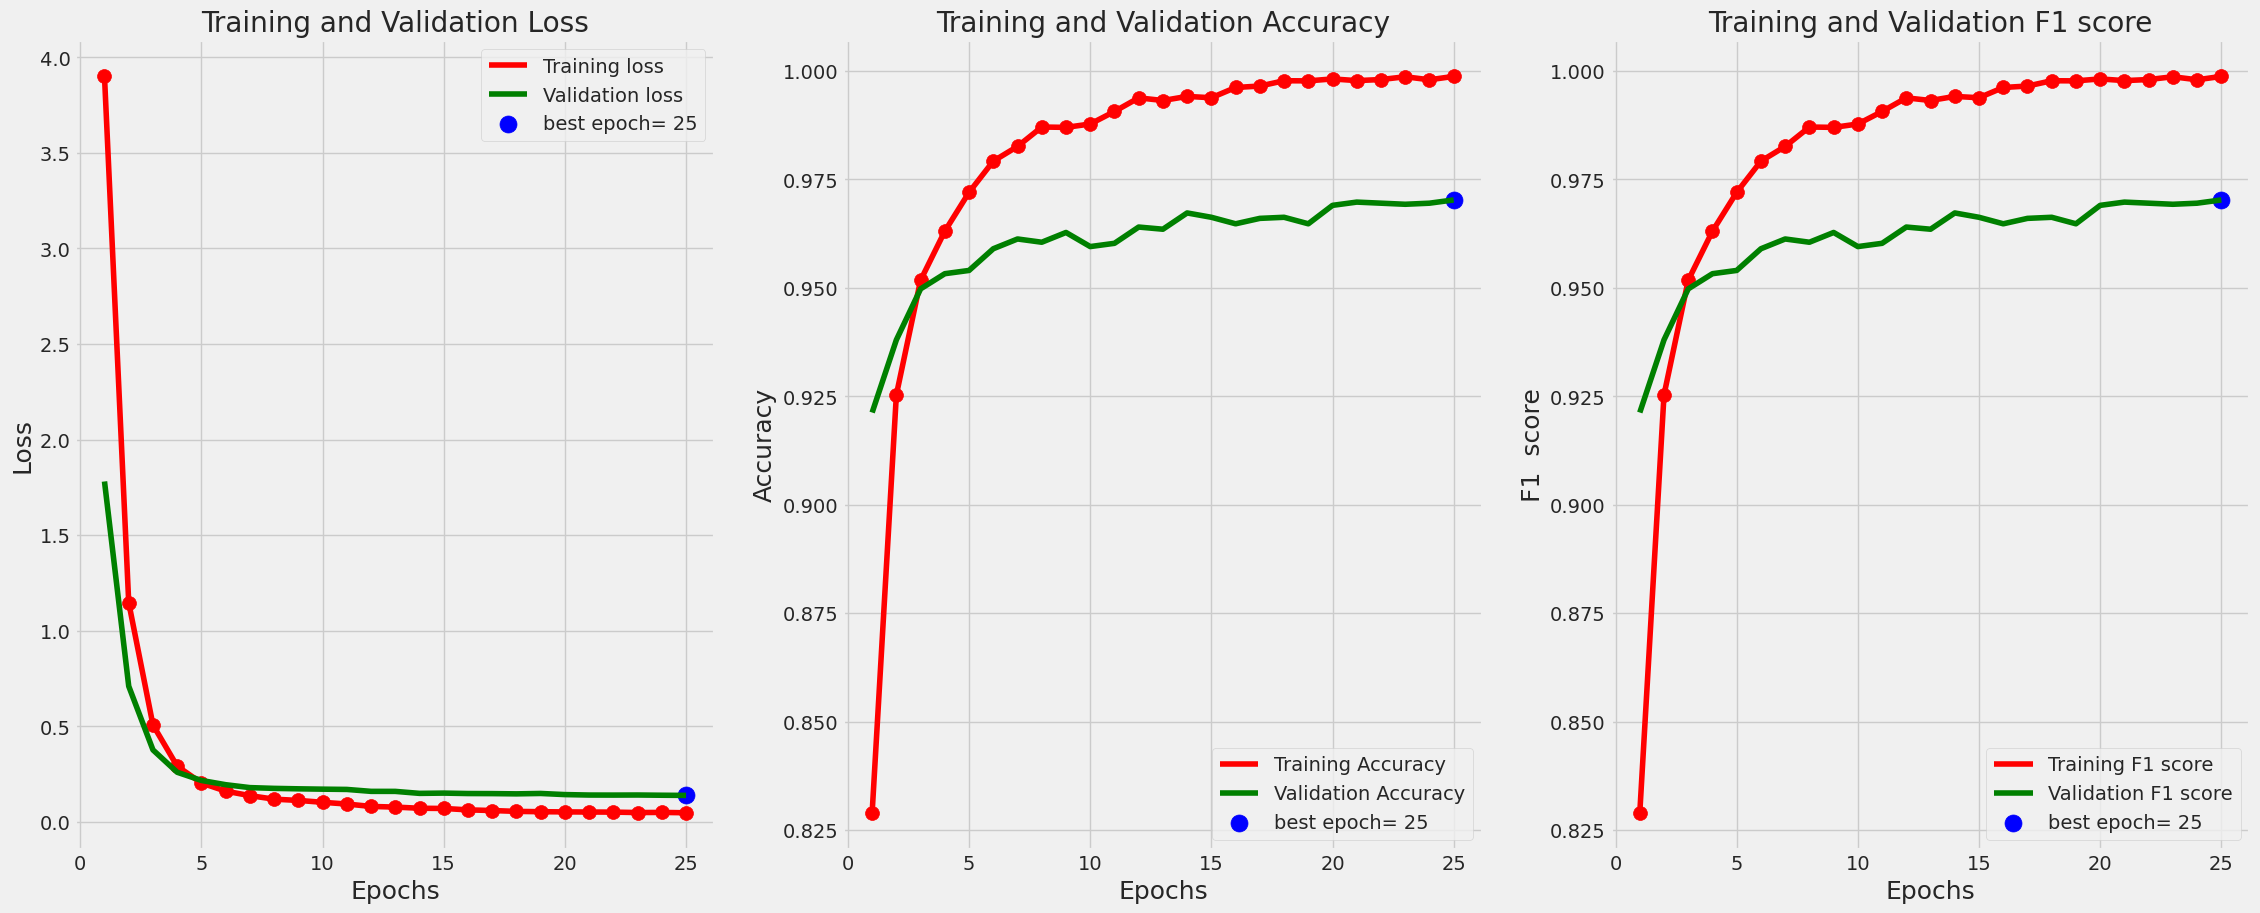

In [44]:
tr_plot(history)

In [45]:
def predictor(model,test_gen):
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    preds=model.predict(test_gen, verbose=1)
    errors=0
    test_count =len(preds)
    misclassified_classes=[]
    misclassified_files=[]
    misclassified_as = []
    pred_indices=[]
    for i, p in enumerate (preds):
        pred_index=np.argmax(p)
        pred_indices.append(pred_index)
        true_index= test_gen.labels[i]    
        if  pred_index != true_index:        
            errors +=1        
            misclassified_classes.append(classes[true_index])
            misclassified_as.append(classes[pred_index])
            file=test_gen.filenames[i]
            split=file.split('/')
            L=len(split)           
            f=split[L-2] +' '+ split[L-1]  
            misclassified_files.append(f)

    accuracy = (test_count-errors)*100/test_count
    ytrue=np.array(test_gen.labels)
    ypred=np.array(pred_indices)
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    msg=f'There were {errors} errors in {test_count} tests for an accuracy of {accuracy:6.2f} and an F1 score of {f1score:6.2f}'
    print (msg) 
    misclassified_classes=sorted(misclassified_classes)
    if len(misclassified_classes) > 0:
        misclassifications=[]
        for klass in misclassified_classes:
            mis_count=misclassified_classes.count(klass)
            misclassifications.append(mis_count)
        unique=len(np.unique(misclassified_classes)) 
        if unique==1:
            height=int(unique)
        else:
            height =int(unique/2)
        plt.figure(figsize=(10, height))
        plt.style.use('fivethirtyeight')
        plt.barh(misclassified_classes, misclassifications )
        plt.title( 'Classification Errors on Test Set by Class', fontsize=20, color='blue')
        plt.xlabel('NUMBER OF MISCLASSIFICATIONS', fontsize=20, color='blue')
        plt.ylabel('CLASS', fontsize=20, color='blue')
        plt.show()
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
        clr = classification_report(ytrue, ypred, target_names=classes, digits= 4) # create classification report
        print("Classification Report:\n----------------------\n", clr)
    return f1score

100/100 [==============================] - 19s 180ms/step
There were 741 errors in 20000 tests for an accuracy of  96.30 and an F1 score of  96.29


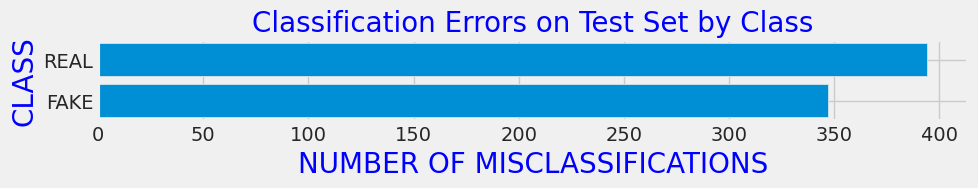

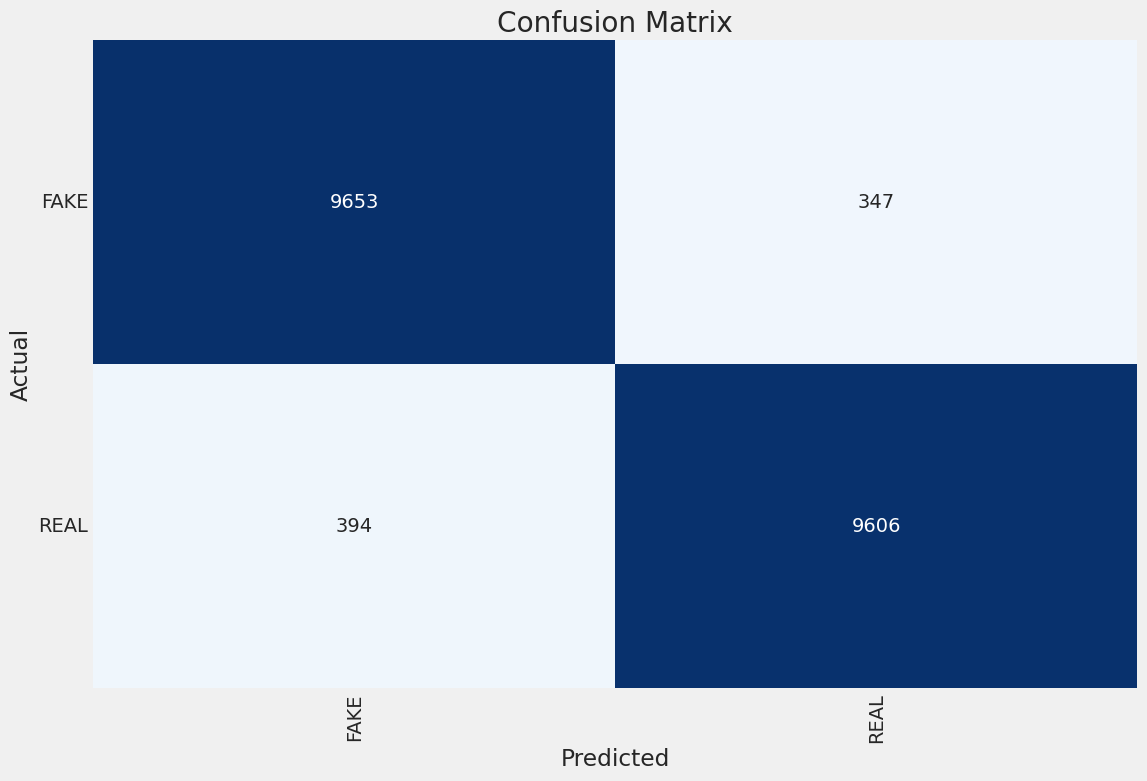

Classification Report:
----------------------
               precision    recall  f1-score   support

        FAKE     0.9608    0.9653    0.9630     10000
        REAL     0.9651    0.9606    0.9629     10000

    accuracy                         0.9629     20000
   macro avg     0.9630    0.9629    0.9629     20000
weighted avg     0.9630    0.9629    0.9629     20000



In [46]:
f1score=predictor(model,test_gen)

In [47]:
def save_model(model,subject, classes, img_size, f1score, working_dir):    
    name=f'{subject}-{str(len(classes))}-({str(img_size[0])} X {str(img_size[1])})- {f1score:5.2f}.h5'    
    model_save_loc=os.path.join(working_dir, name)    
    try:
        model.save(model_save_loc)        
        msg= f'model was saved as {model_save_loc}'
        print_in_color(msg, (0,255,255),(0,0,0))
    except:
        msg='model can not be saved due to tensorflow 2.10.0 or higher. Bug involving use of EfficientNet Models'        
        print_in_color(msg, (0,255,255), (0,0,0)) # cyan foreground

In [50]:
subject='Real vs Fake Images'
working_dir=r'/scratch/rharikr3/working/'
save_model(model,subject, classes, img_size, f1score, working_dir)

model was saved as /scratch/rharikr3/working/Real vs Fake Images-2-(32 X 32)- 96.29.h5
